In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from keras import regularizers
import pickle

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 12

## Load Data

In [3]:
labels_to_names = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

4423680/4422102 [==============================] - 2s 0us/step


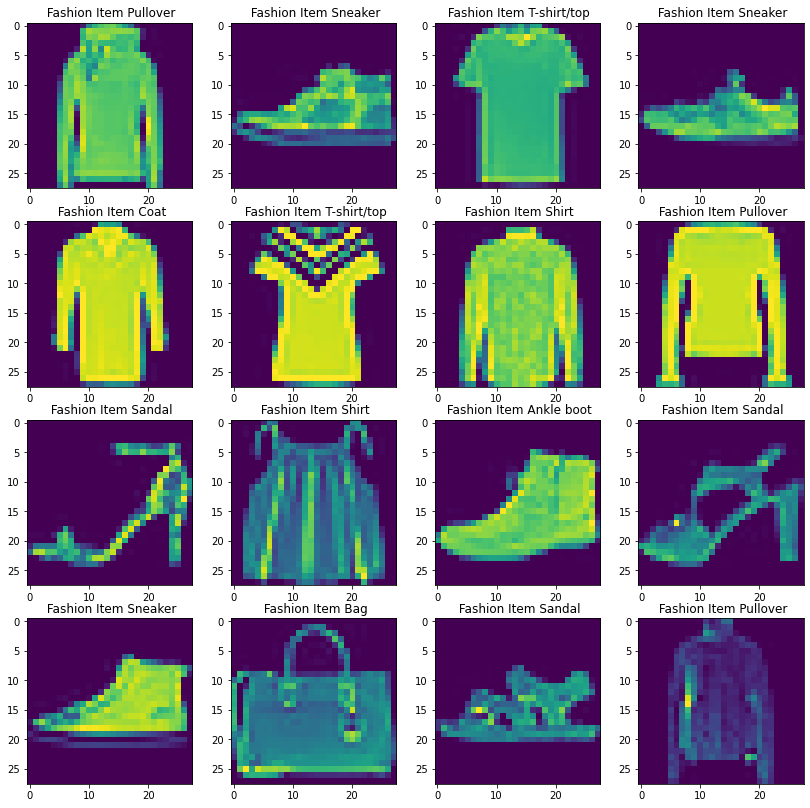

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

sample_size = 50
rand_indexes = np.random.randint(0, len(x), sample_size)
fig, axis = plt.subplots(4, 4, figsize=(14, 14))
for i, ax in enumerate(axis.flat):
    n=random.randint(0,40000)
    ax.imshow(x_train[n])
    ax.set(title= " Fashion Item " + str(labels_to_names[y_train[n]]) )
  
x = x.reshape(x.shape[0], img_rows, img_cols, 1)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(x)

In [6]:
i = 1
x_temp = x
y_temp = y
while i<5:
  d1 = datagen.flow(x, y,batch_size=70000)
  x1,y1=d1.next()
  x_temp = np.append(x_temp,x1,axis=0)
  y_temp = np.append(y_temp,y1,axis=0)
  i+=1
print(x_temp.shape)
print(y_temp.shape)

(350000, 28, 28, 1)
(350000,)


In [7]:
# pickle.dump((x_temp,y_temp), open('pickle.p', 'wb')) # to write 'arr' to disk
# aug_dataset_tuple = pickle.load(open('pickle.p', 'rb')) # to read 'arr' from disk

In [8]:
x, y = aug_dataset_tuple
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=13)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(224000, 28, 28, 1)
(224000,)
(56000, 28, 28, 1)
(56000,)


# Format the data for training

# Normilize

In [10]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_val = x_val.astype('float32')/255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_val shape:', x_val.shape)



x_train shape: (224000, 28, 28, 1)
x_test shape: (70000, 28, 28, 1)
x_val shape: (56000, 28, 28, 1)


## One-hot encoding

In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [14]:
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [16]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# reduce learning rate by a factor of 10 of val_loss 
# does not reduce for 3 epochs
c1 = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=5,min_lr=0.0000001)
# Early stop training if val_acc falls or stays flat for 7 epochs
c2 = EarlyStopping(monitor='val_loss',patience=8)

## Building the neural network

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)       

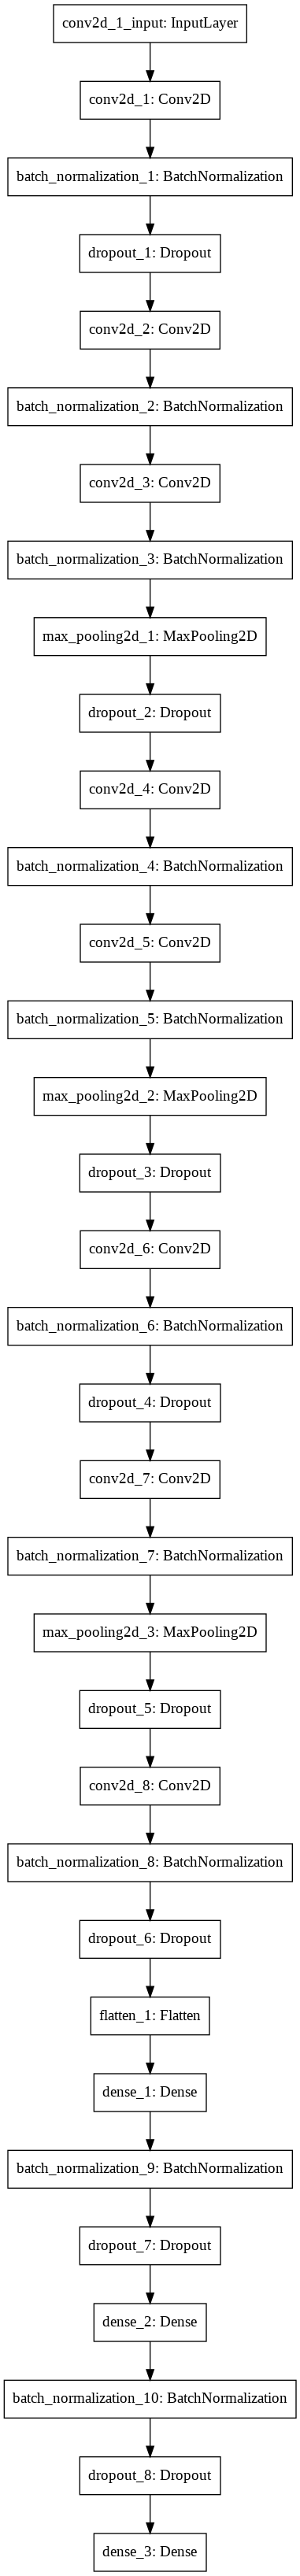

In [19]:
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import pydot
# import graphviz
import pydotplus
from IPython.display import SVG

tf.keras.utils.plot_model(model, to_file='model.png')
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [20]:
history = model.fit(x_train,y_train, batch_size=batch_size,epochs = epochs, 
                              validation_data = (x_val, y_val), verbose=1,
                              callbacks = [c1,c2])

Train on 224000 samples, validate on 56000 samples
Epoch 1/12
224000/224000 [==============================] - 280s 1ms/step - loss: 0.6847 - accuracy: 0.7542 - val_loss: 0.4739 - val_accuracy: 0.8301
Epoch 2/12
224000/224000 [==============================] - 271s 1ms/step - loss: 0.4113 - accuracy: 0.8519 - val_loss: 0.3699 - val_accuracy: 0.8669
Epoch 3/12
224000/224000 [==============================] - 271s 1ms/step - loss: 0.3454 - accuracy: 0.8764 - val_loss: 0.2959 - val_accuracy: 0.8929
Epoch 4/12
224000/224000 [==============================] - 271s 1ms/step - loss: 0.3091 - accuracy: 0.8890 - val_loss: 0.2721 - val_accuracy: 0.9008
Epoch 5/12
224000/224000 [==============================] - 271s 1ms/step - loss: 0.2797 - accuracy: 0.9001 - val_loss: 0.3127 - val_accuracy: 0.8874
Epoch 6/12
224000/224000 [==============================] - 271s 1ms/step - loss: 0.2567 - accuracy: 0.9083 - val_loss: 0.2676 - val_accuracy: 0.9027
Epoch 7/12
224000/224000 [=======================

In [21]:
## Modle 

In [22]:
# model.save_weights('9301_model.h5')


In [23]:
score_val = model.evaluate(x_val, y_val, verbose=0)

print('Validation loss:', score_val[0])
print('Validation accuracy:', score_val[1])

Validation loss: 0.19547169989041452
Validation accuracy: 0.9300535917282104


In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score

test_predictions = model.predict_classes(x_test)

cm = confusion_matrix(np.argmax(y_test, axis=1), test_predictions)
score = accuracy_score(np.argmax(y_test, axis=1), test_predictions)
print(cm)

[[6288    2  108  123    3    7  417    0   21    3]
 [   0 6996    3   33    2    3    7    1    5    0]
 [  98    4 6470   79  132    2  171    0    4    0]
 [  87   22   25 6702  102    8   89    1    2    2]
 [  13    6  445  193 6133    2  292    1   12    0]
 [   0    0    0    1    0 6920    0   57    2   31]
 [ 655   12  456  158  335    3 5306    1   25    2]
 [   0    0    0    1    0   89    0 6813    3  136]
 [  14    1    8   10    8   34   15    7 6820    3]
 [   1    0    0    2    0   50    1  231    2 6668]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Test Accuracy Score: 0.9302285714285714')

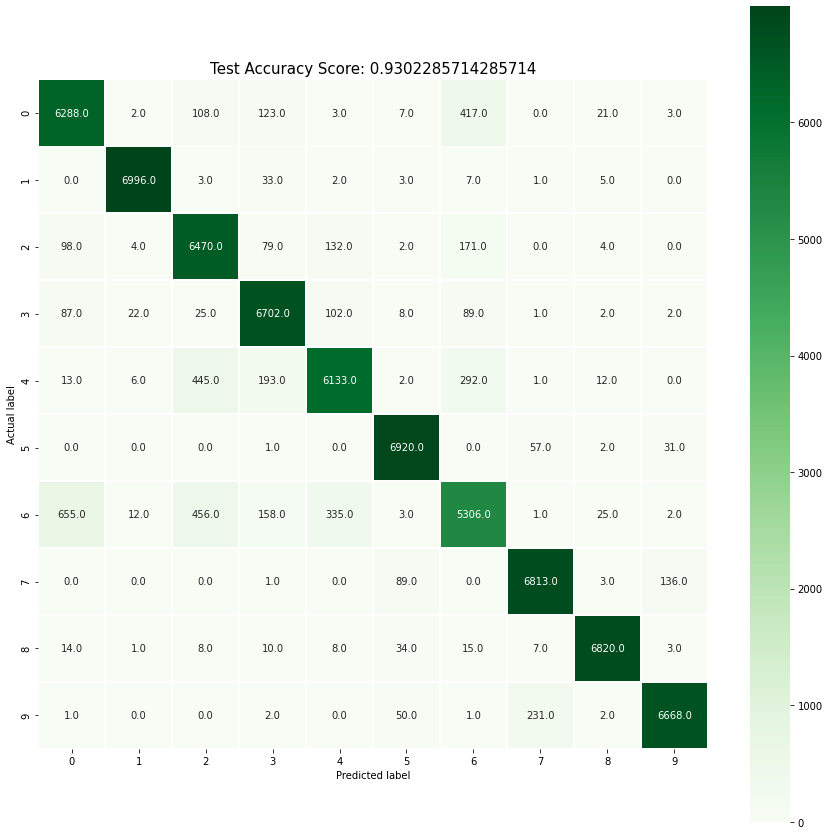

In [25]:
import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Test Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

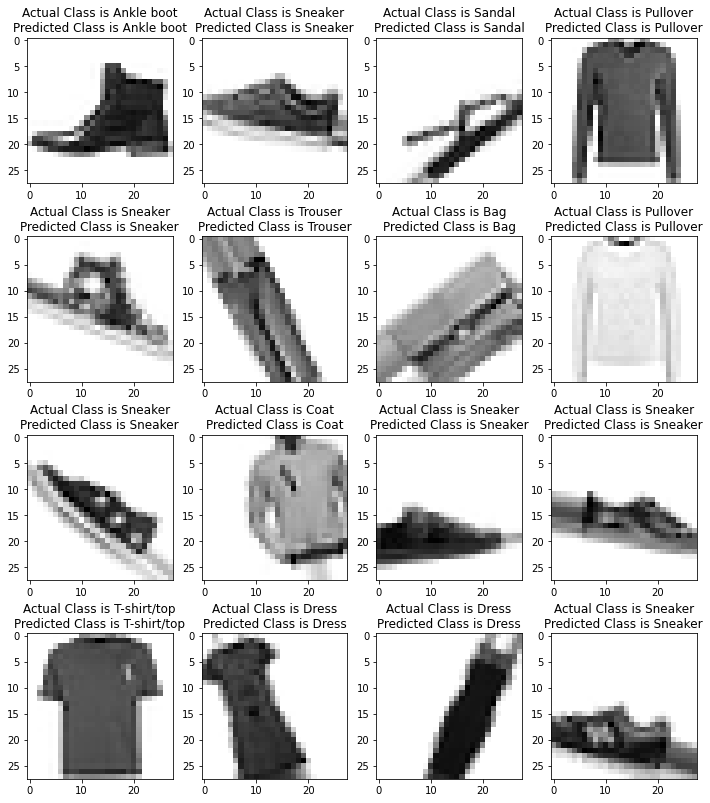

In [26]:
y_pred = model.predict(x_test)
x_test__ = x_test.reshape(x_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_test__[i], cmap='binary')
    ax.set(title = f"Actual Class is {labels_to_names[y_test[i].argmax()]}\nPredicted Class is {labels_to_names[y_pred[i].argmax()]}")

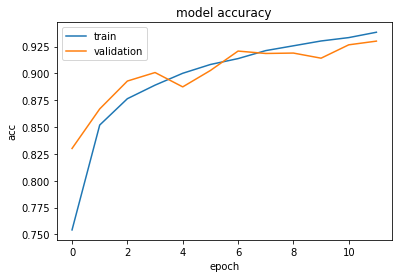

In [27]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

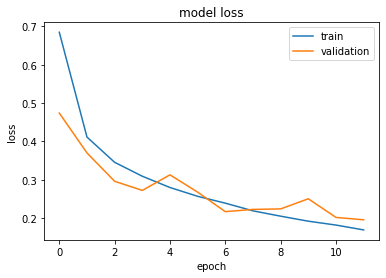

In [28]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')